## IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

import holidays

## READING DATA

In [2]:
#PLANT DATA
#Source file path
path = r"C:\01 PRZENIESIENIE\KPEC BYDGOSZCZ\01MODELOWANIE\Diagnostyka_KPEC_calosciowo.xlsm"


#Indexes we don't want to read from file
elements = [37,38,40,44]

#Indexes of columns to read 
index_col = [number for number in range(65) if number not in elements]

#Sheet name in Excel file
sheet_name = 'Dane 2019-2021'

#Reading data from Excel file
dataset = pd.read_excel(path,
                        sheet_name = sheet_name,
                        usecols = index_col)


#Convert column into datetime format
dataset['DataCzas'] = pd.to_datetime(dataset['DataCzas'])

#Set new index with datetime
dataset.set_index('DataCzas', drop = True, inplace = True)


#Read the dataframe with meteo data
dataMeteo = pd.read_excel(r"C:\01 PRZENIESIENIE\KPEC BYDGOSZCZ\01MODELOWANIE\Nasłonecznienie i wiatr.xlsx",
                         engine = 'openpyxl')
#Delete first row with units
dataMeteo = dataMeteo.iloc[1:,:]

#Change names of columns
dataMeteo.columns = ['DataCzas','Promieniowanie','PredkoscWiatru']

#Change time column format
dataMeteo['DataCzas'] = pd.to_datetime(dataMeteo['DataCzas'])

#Set new index of dataframe
dataMeteo.set_index("DataCzas" , inplace = True)

#Replace (null) values
dataMeteo.replace("(null)",0, inplace = True)

#Change type of data
for column in dataMeteo.columns:
    dataMeteo[column] = pd.to_numeric(dataMeteo[column])

#Filter dataMeteo by time  from df1
dataMeteo = dataMeteo[dataMeteo.index <= dataset.index.max()]

#Change index of df1
dataset.index = pd.date_range(dataset.index.min(), dataset.index.max() + pd.DateOffset(hours=1), freq = 'H')

#Change index name
dataset.index.name = 'DataCzas'

#Merge meteo data with plants data
data = pd.merge(dataset, dataMeteo, on = 'DataCzas', how = 'left')

#Define df1 droping last row
dataset = data.iloc[:-1,:].copy()



## FEATURE ENGINEERING

In [3]:
#Copy oryginal dataset info df
df1 = dataset.copy()

#Add additional features
#Hour
df1['Godzina'] = df1.index.hour

#Day of week number
df1['DzieńTygodnia'] = df1.index.dayofweek

#Quarter of the year
df1['Kwartał'] = df1.index.quarter

#Add info if given day is a holiday
#List of holidays
pl_holidays = holidays.Poland(years=[df1.index.year.min(), df1.index.year.max()])

#Range of dates
range_of_dates = pd.date_range(str(df1.index.min())[:10], str(df1.index.max())[:10]) # [:10] delete time from timestamp value

#Add column with holiday boolean value
df1['Swieto'] = [index in pl_holidays for index in df1.index]

#Convertion index of month into x, y coordinates on the cirlce
df1['Miesiac_x'] = df1['Miesiac'].apply(lambda x: np.sin(2 * np.pi * x / 12))
df1['Miesiac_y'] = df1['Miesiac'].apply(lambda x: np.cos(2 * np.pi * x / 12))

#Convertion index of hour into x, y coordinates on the cirlce
df1['Godzina_x'] = df1['Godzina'].apply(lambda x: np.sin(2 * np.pi * x / 24))
df1['Godzina_y'] = df1['Godzina'].apply(lambda x: np.cos(2 * np.pi * x / 24))

#Convertion index of u=quarter into x, y coordinates on the cirlce
df1['Kwartał_x'] = df1['Kwartał'].apply(lambda x: np.sin(2 * np.pi * x / 4))
df1['Kwartał_y'] = df1['Kwartał'].apply(lambda x: np.cos(2 * np.pi * x / 4))

#Convertion index of day of the week into x, y coordinates on the cirlce
df1['DzieńTygodnia_x'] = df1['DzieńTygodnia'].apply(lambda x: np.sin(2 * np.pi * x / 7))
df1['DzieńTygodnia_y'] = df1['DzieńTygodnia'].apply(lambda x: np.cos(2 * np.pi * x / 7))

#Filter dataset with given columns
# df1 = df[['Rok', 
#           'Miesiac', 
#           'Dzień', 
#           'Okres\ngrzewczy',
#           'Temp powietrza\n zewn - licznik\n[°C]',
#           'Moc Miasto obl.\n[MW]',
#           #'Moc Fordon obl.\n[MW]',
#           'Moc EC1 obl.\n[MW]',
#           'Moc ZTPOK obl.\n[MW]',
#           'Moc BialeBlota\n[MW]',
#           #'Moc SUMA obl.\n[MW]'
#          ]].copy()



#Rename columns from origial ones
df1.rename({#'Moc SUMA obl.\n[MW]': 'Moc', 
            'Okres\ngrzewczy': 'OkresGrzewczy',
           'Temp powietrza\n zewn - licznik\n[°C]': "TempZewn",
           'Moc Miasto obl.\n[MW]': 'MocMiasto',
           #'Moc Fordon obl.\n[MW]': 'MocFordon',
           'Moc EC1 obl.\n[MW]' :'MocECI',
           'Moc ZTPOK obl.\n[MW]' :'MocZTPOK',
           'Moc BialeBlota\n[MW]' : 'MocBialeBlota'}, axis = 1, inplace = True)



#List of column to filter dataframe
kolumny = ['Rok', 
           #'Kwartał',
           'Kwartał_x',
           'Kwartał_y',
           #'Miesiac',
           'Miesiac_x',
           'Miesiac_y',
           'Dzień', 
           #'DzieńTygodnia',
           'DzieńTygodnia_x',
           'DzieńTygodnia_y',
           #'Godzina',
           'Godzina_x',
           'Godzina_y',
           'OkresGrzewczy',
           'Swieto',
           'TempZewn',
           'Promieniowanie',
           'PredkoscWiatru',
           'MocMiasto',
           #'MocFordon',
           'MocECI',
           'MocZTPOK',
           'MocBialeBlota',
           #'Moc'
          ]

#Filter dataframe by given columns
df1 = df1[kolumny]

#Delete outliers from meteo data
df1['Promieniowanie'][(df1['Promieniowanie'] > 1000) | (df1['Promieniowanie'] < 0)] = np.nan
df1['PredkoscWiatru'][(df1['PredkoscWiatru'] > 27) | (df1['PredkoscWiatru'] < 0)] = np.nan

#Fill null values
df1['Promieniowanie'].fillna(0, inplace = True)
df1['PredkoscWiatru'].fillna(0, inplace = True)

#Fill null values with defined values
df1['MocBialeBlota'].fillna(0, inplace = True)
df1['OkresGrzewczy'].fillna("nOg", inplace = True)

#Interpolate missing values using interpolation as a first, easy method
df1['MocMiasto'] = df1['MocMiasto'].interpolate()
df1['MocECI'] = df1['MocECI'].interpolate()
df1['MocZTPOK'] = df1['MocZTPOK'].interpolate()
df1['TempZewn'] = df1['TempZewn'].interpolate()

#Calculate Y column i.e. 'Moc' based on power from other plants
df1['Moc'] = df1['MocMiasto'] + df1['MocECI'] + df1['MocZTPOK'] + df1['MocBialeBlota'] 



### ONE-HOT ENCODING

In [4]:
#List of column to encode
columnToEncode = ['OkresGrzewczy','Swieto']

#Empty list to fill in
idxToEncode = []

#Iterate through df1.columns and return indexes of columns to encode
for idx, column in enumerate(df1.columns):
    if column in columnToEncode:
        idxToEncode.append(idx)
        

#Definition of one-hot encoding object for OkresGrzewczy and Swieto columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), idxToEncode)], remainder='passthrough')

#One-hot encoding
df2 = ct.fit_transform(df1)

#Column names for new dataframe
df2Columns = ['nOg',
               'og',
               'nSwieto',
               'Swieto',
            'Rok', 
           #'Kwartał',
           'Kwartał_x',
           'Kwartał_y',
           #'Miesiac',
           'Miesiac_x',
           'Miesiac_y',
           'Dzień', 
           #'DzieńTygodnia',
            'DzieńTygodnia_x',
           'DzieńTygodnia_y',
           #'Godzina',
           'Godzina_x',
           'Godzina_y',
           #'OkresGrzewczy',
           #'Swieto',
           'TempZewn',
            'Promieniowanie',
           'PredkoscWiatru',
           'MocMiasto',
           #'MocFordon',
           'MocECI',
           'MocZTPOK',
           'MocBialeBlota',
           'Moc'
          ]
#Creating of new dataframe
df2 = pd.DataFrame(df2, index = df1.index, columns = df2Columns)

# df2.columns = ['nOg',
#                'og',
#                'nSwieto',
#                'Swieto',
#                'Rok', 
#                'Kwartał', 
#                'Miesiac', 
#                'Dzień', 
#                #'DzieńTygodnia',
#                'Godzina',
#                'TempZewn',
#                'MocMiasto',
#                #'MocFordon',
#                'MocECI', 
#                'MocZTPOK',
#                'MocBialeBlota',
#                'Moc']

#Changing the name of df
df1 = df2.copy()



### Shifting of the columns

In [5]:
#Names for shifted columns
#Power columns
namesMoc = [f"MocLag{i}" for i in range(24,49)]
#Temperature columns
namesTemp = [f"TempLag{i}" for i in range(24,49)]
 
#Shifting of columns
#Power
for idx,name in enumerate(namesMoc):
    df1[name] = df1['Moc'].shift(-idx-1-24)

#Temperature    
for idx,name in enumerate(namesTemp):
    df1[name] = df1['TempZewn'].shift(-idx-1-24)

#Adding of new column with rolling mean of temperature value
df1['TempZewnMean12'] = df1['TempZewn'].rolling(12).mean()

#Deleting of rows with NaN values created by shifting of columns and adding rolling temperature
df1 = df1.iloc[11:-49,:].copy()



In [6]:
df1.columns

Index(['nOg', 'og', 'nSwieto', 'Swieto', 'Rok', 'Kwartał_x', 'Kwartał_y',
       'Miesiac_x', 'Miesiac_y', 'Dzień', 'DzieńTygodnia_x', 'DzieńTygodnia_y',
       'Godzina_x', 'Godzina_y', 'TempZewn', 'Promieniowanie',
       'PredkoscWiatru', 'MocMiasto', 'MocECI', 'MocZTPOK', 'MocBialeBlota',
       'Moc', 'MocLag24', 'MocLag25', 'MocLag26', 'MocLag27', 'MocLag28',
       'MocLag29', 'MocLag30', 'MocLag31', 'MocLag32', 'MocLag33', 'MocLag34',
       'MocLag35', 'MocLag36', 'MocLag37', 'MocLag38', 'MocLag39', 'MocLag40',
       'MocLag41', 'MocLag42', 'MocLag43', 'MocLag44', 'MocLag45', 'MocLag46',
       'MocLag47', 'MocLag48', 'TempLag24', 'TempLag25', 'TempLag26',
       'TempLag27', 'TempLag28', 'TempLag29', 'TempLag30', 'TempLag31',
       'TempLag32', 'TempLag33', 'TempLag34', 'TempLag35', 'TempLag36',
       'TempLag37', 'TempLag38', 'TempLag39', 'TempLag40', 'TempLag41',
       'TempLag42', 'TempLag43', 'TempLag44', 'TempLag45', 'TempLag46',
       'TempLag47', 'TempLag48', 'Tem

In [15]:
#Defining the list of columns to model training
kolumny = ['og', 'Swieto', 'Rok', 'Kwartał_x','Kwartał_y', 'Miesiac_x','Miesiac_y', 'Dzień', 'Godzina_x','Godzina_y',
       'TempZewn', 'TempZewnMean12', 'Promieniowanie', 'PredkoscWiatru', 'MocMiasto', 'MocECI', 'MocZTPOK',
       'MocBialeBlota', 'TempLag24', 'TempLag25', 'TempLag26',
       'TempLag27', 'TempLag28', 'TempLag29', 'TempLag30', 'TempLag31',
       'TempLag32', 'TempLag33', 'TempLag34', 'TempLag35', 'TempLag36',
       'TempLag37', 'TempLag38', 'TempLag39', 'TempLag40', 'TempLag41',
       'TempLag42', 'TempLag43', 'TempLag44', 'TempLag45', 'TempLag46',
       'TempLag47', 'TempLag48', 'MocLag24',
       'MocLag25', 'MocLag26', 'MocLag27', 'MocLag28', 'MocLag29', 'MocLag30',
       'MocLag31', 'MocLag32', 'MocLag33', 'MocLag34', 'MocLag35', 'MocLag36',
       'MocLag37', 'MocLag38', 'MocLag39', 'MocLag40', 'MocLag41', 'MocLag42',
       'MocLag43', 'MocLag44', 'MocLag45', 'MocLag46', 'MocLag47', 'MocLag48', 'Moc']

#Training dataset horizon definition
train = df1.iloc[np.where(df1.index < '2021-03-01')]

#Test dataset horizon definition
test = df1.iloc[np.where(df1.index >= '2021-03-01')]

#List of features columns
FEATURES = kolumny[:-1]

#List of target column
TARGET = kolumny[-1]

#Division X columns into train and test dataset
X_train = train[FEATURES]
X_test = test[FEATURES]

#Division Y column into train and test dataset
y_train = train[TARGET]
y_test = test[TARGET]

### TRAINING OF MODEL

In [52]:
#List of n_estimators values
listEstimators = [100,250,
                  500
                  ,750,1000,1500,2000, 2500, 3000, 3500, 4000, 4500, 5000
                        ]
#Empty list to store metrics and quality of model
results = []

#Loop training the model and checking the quality for different n_estimators value
for n_estimators in listEstimators:

    #XGB regressor object
    reg = xgb.XGBRegressor(base_score = 0.5,
                               booster = 'gbtree',
                               n_estimators = n_estimators,
                               early_stopping_rounds = 50,
                               objective = 'reg:squarederror',
                               max_depth = 3,
                               learning_rate = 0.01)
    #Training of the model
    reg.fit(X_train, y_train,
           eval_set = [(X_train, y_train),(X_test, y_test)],
           verbose = False)

    #Making the prediction on a test set
    test['Predykcja'] = reg.predict(X_test)

    #Calculating the R2 metric
    R2 = round(r2_score(test['Moc'], test['Predykcja']),5)
    
    #Calculating the MAPE metric
    MAPE = round(mape(test['Moc'], test['Predykcja']),4)

    print(f'N_estimators: {n_estimators}, Metrics for prediction: \n - R2 = {R2} \n - MAPE = {MAPE*100}%')
    print()
    print("****************")

    #Adding metrics and n_Estimators value into list
    results.append([R2,MAPE,n_estimators])

#Creating the dataframe with metrics and n_estimator
resultsDf = pd.DataFrame(results, columns = ['R2','MAPE','n_estimators'])
resultsDf

N_estimators: 100, Metrics for prediction: 
 - R2 = 0.55188 
 - MAPE = 35.010000000000005%

****************
N_estimators: 250, Metrics for prediction: 
 - R2 = 0.97034 
 - MAPE = 9.82%

****************
N_estimators: 500, Metrics for prediction: 
 - R2 = 0.99499 
 - MAPE = 5.52%

****************
N_estimators: 750, Metrics for prediction: 
 - R2 = 0.99621 
 - MAPE = 4.92%

****************
N_estimators: 1000, Metrics for prediction: 
 - R2 = 0.99693 
 - MAPE = 4.52%

****************
N_estimators: 1500, Metrics for prediction: 
 - R2 = 0.9976 
 - MAPE = 4.130000000000001%

****************
N_estimators: 2000, Metrics for prediction: 
 - R2 = 0.998 
 - MAPE = 3.8%

****************
N_estimators: 2500, Metrics for prediction: 
 - R2 = 0.99828 
 - MAPE = 3.51%

****************
N_estimators: 3000, Metrics for prediction: 
 - R2 = 0.9985 
 - MAPE = 3.2399999999999998%

****************
N_estimators: 3500, Metrics for prediction: 
 - R2 = 0.99863 
 - MAPE = 3.08%

****************
N_estima

,R2,MAPE,n_estimators
0,0.55188,0.3501,100
1,0.97034,0.0982,250
2,0.99499,0.0552,500
3,0.99621,0.0492,750
4,0.99693,0.0452,1000
5,0.99760,0.0413,1500
6,0.99800,0.0380,2000
7,0.99828,0.0351,2500
8,0.99850,0.0324,3000
9,0.99863,0.0308,3500


### PLOTING THE RESULTS

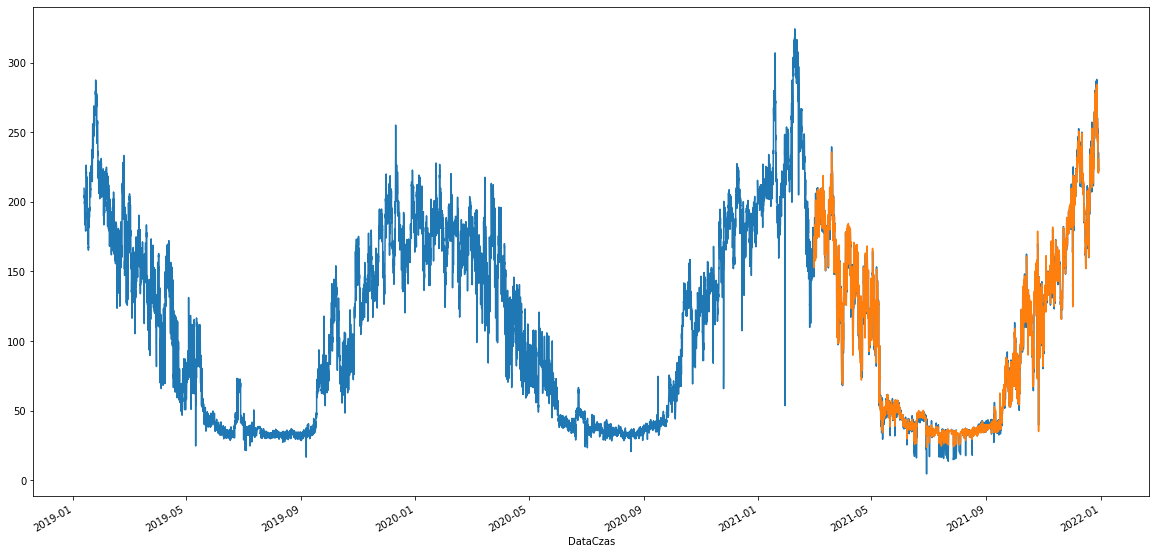

In [53]:
#Plot of original data with predicted values from testset
fig, ax = plt.subplots(figsize = (20,10))
df1['Moc'].plot(ax = ax)
test['Predykcja'].plot(ax = ax)
plt.show()

### PLOTING DEVIATION OF THE PREDICTED VALUE FROM THE TRUE VALUE.

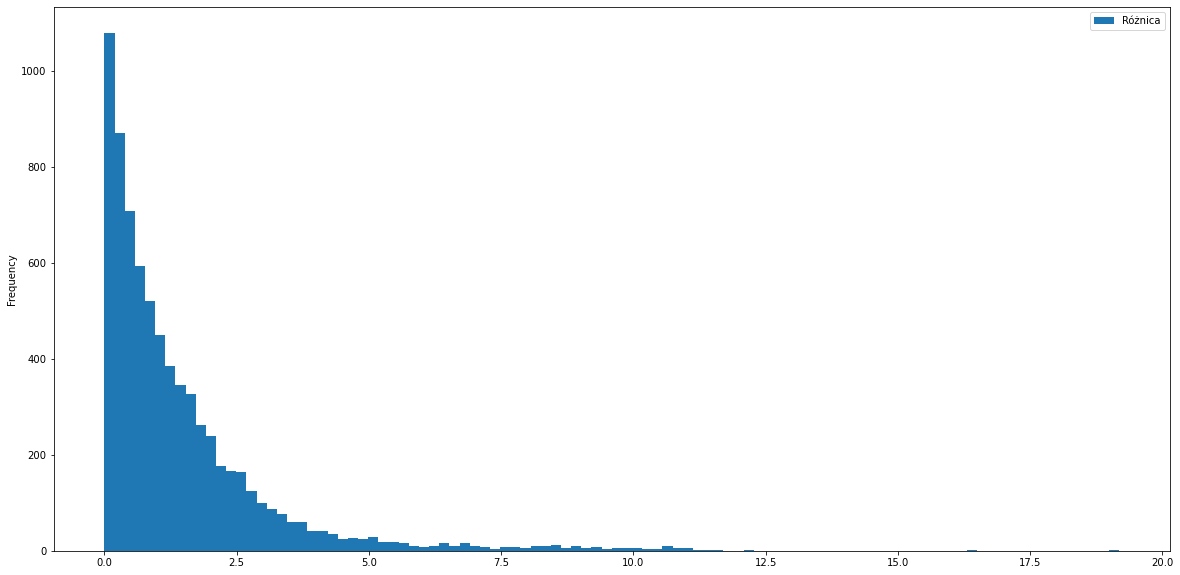

In [54]:
test['Różnica'] = abs(test['Moc'] - test['Predykcja'])
test.plot(kind = 'hist' ,y = 'Różnica', bins = 100, figsize = (20,10))
plt.show()

### PLOTING FUTURE IMPORTANCES

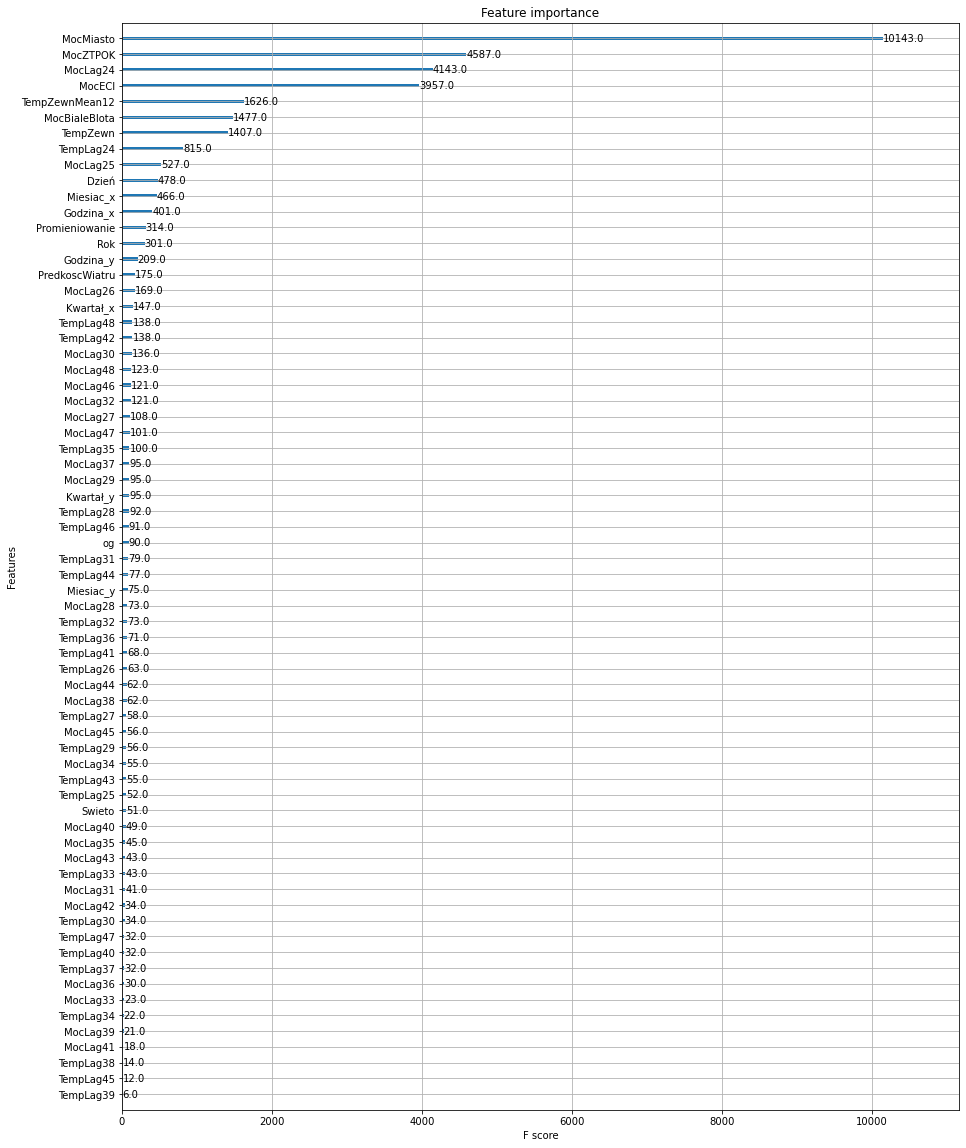

In [55]:
# plot feature importance
fig, ax = plt.subplots(figsize = (15,20))
xgb.plot_importance(reg, ax = ax)
plt.show()

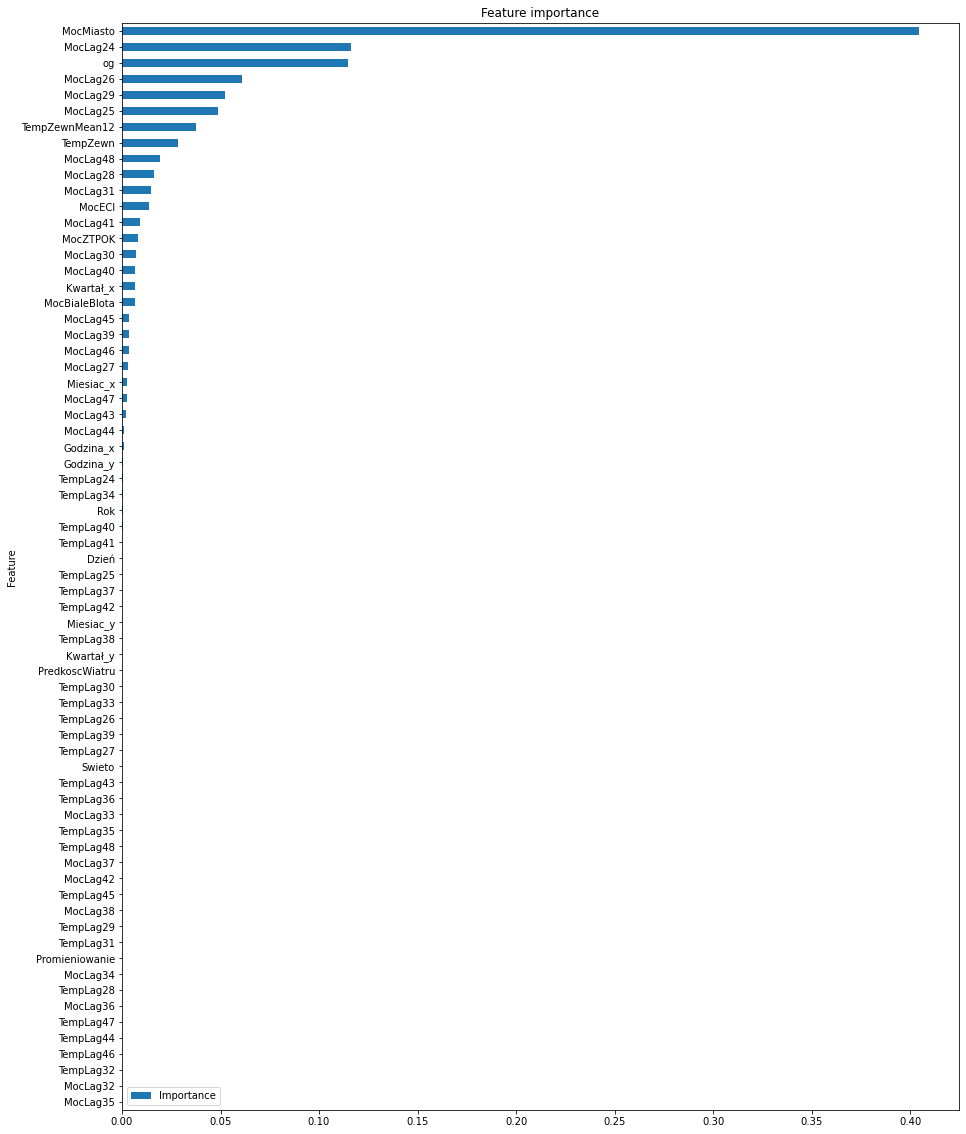

In [56]:
imp = pd.DataFrame(columns = ['Feature','Importance'])
imp['Feature'] = reg.get_booster().feature_names
imp['Importance'] = reg.feature_importances_
fig,ax = plt.subplots(figsize = (15,20))
imp.sort_values(by = 'Importance', ascending = True).set_index('Feature').plot(kind = 'barh', ax = ax)
plt.title("Feature importance")
plt.show()

### PLOTING MAPE AND R2 VALUES FOR GIVEN NUMBER OF N_ESTIMATORS

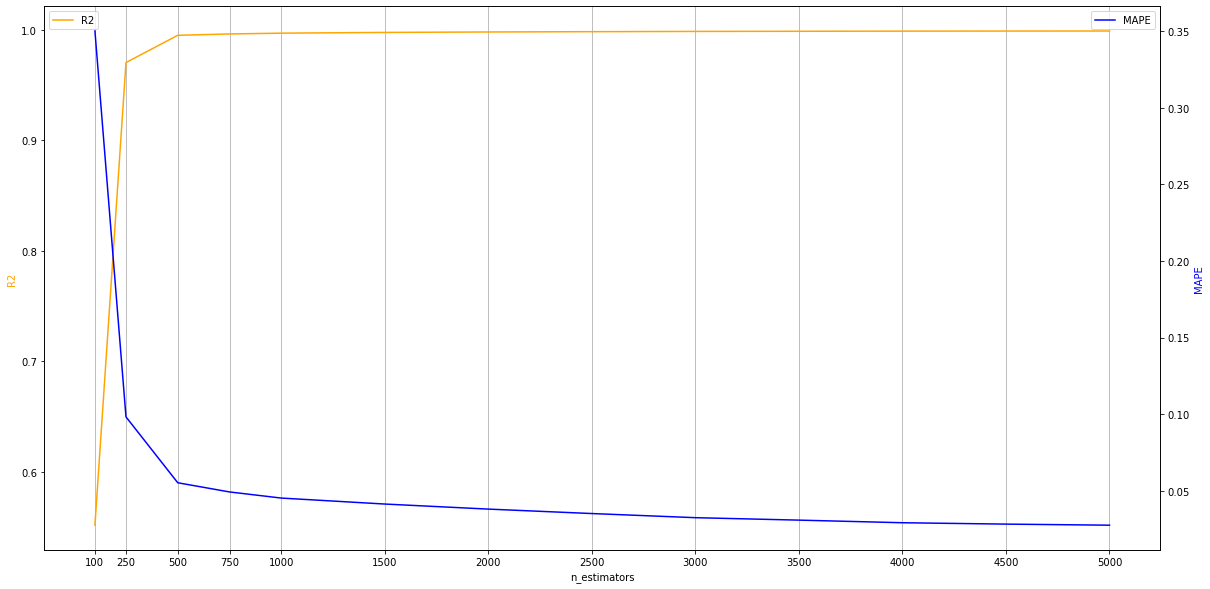

In [57]:
fig, ax = plt.subplots(figsize = (20,10))
ax2 = ax.twinx()
resultsDf.plot(x = 'n_estimators', y = 'R2', ax = ax, color = 'orange' , label = 'R2')
resultsDf.plot(x = 'n_estimators', y = 'MAPE', ax = ax2, color = 'blue', label = 'MAPE')
ax.legend(loc = 1)
ax.legend(loc = 2)
ax.set_ylabel('R2', color = 'orange')
ax2.set_ylabel('MAPE', color = 'blue')
ax.grid(axis = 'x')
plt.xticks(listEstimators)
plt.show()